# Projet 3 : Concevez une application au service de la santé

**Chargement des librairies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option('display.max_rows', 162)
pd.set_option('display.max_columns', 162)

## Présentation et sélection des variables pertinentes

C:\Users\aurel\AppData\Local\Temp\ipykernel_6988\4194003184.py:4: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep = "\t")


Le jeu de données comporte 320772 lignes et 162 colonnes


last_modified_t                               0.000000
last_modified_datetime                        0.000000
creator                                       0.000006
created_t                                     0.000009
created_datetime                              0.000028
code                                          0.000072
url                                           0.000072
states                                        0.000143
states_tags                                   0.000143
states_fr                                     0.000143
countries_fr                                  0.000873
countries                                     0.000873
countries_tags                                0.000873
product_name                                  0.055373
brands                                        0.088574
brands_tags                                   0.088599
energy_100g                                   0.185986
proteins_100g                                 0.189699
salt_100g 

,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g
count,2.611130e+05,259922.000000,255510.000000,255463.000000,244971.000000,243891.000000,243588.000000,229554.000000,200886.000000
mean,1.141915e+03,7.075940,2.028624,0.798815,16.003484,12.730379,32.073981,5.129932,2.862111
std,6.447154e+03,8.409054,128.269454,50.504428,22.327284,17.578747,29.731719,8.014238,12.867578
min,0.000000e+00,-800.000000,0.000000,0.000000,-17.860000,0.000000,0.000000,0.000000,-6.700000
25%,3.770000e+02,0.700000,0.063500,0.025000,1.300000,0.000000,6.000000,0.000000,0.000000
50%,1.100000e+03,4.760000,0.581660,0.229000,5.710000,5.000000,20.600000,1.790000,1.500000
75%,1.674000e+03,10.000000,1.374140,0.541000,24.000000,20.000000,58.330000,7.140000,3.600000
max,3.251373e+06,430.000000,64312.800000,25320.000000,3520.000000,714.290000,2916.670000,550.000000,5380.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        303010 non-null  object 
 1   countries_fr        320492 non-null  object 
 2   pnns_groups_2       94491 non-null   object 
 3   energy_100g         261113 non-null  float64
 4   proteins_100g       259922 non-null  float64
 5   salt_100g           255510 non-null  float64
 6   sodium_100g         255463 non-null  float64
 7   sugars_100g         244971 non-null  float64
 8   fat_100g            243891 non-null  float64
 9   carbohydrates_100g  243588 non-null  float64
 10  saturated-fat_100g  229554 non-null  float64
 11  fiber_100g          200886 non-null  float64
 12  nutrition_grade_fr  221210 non-null  object 
dtypes: float64(9), object(4)
memory usage: 31.8+ MB


None

countries_fr          0.000873
product_name          0.055373
energy_100g           0.185986
proteins_100g         0.189699
salt_100g             0.203453
sodium_100g           0.203599
sugars_100g           0.236308
fat_100g              0.239675
carbohydrates_100g    0.240620
saturated-fat_100g    0.284370
nutrition_grade_fr    0.310382
fiber_100g            0.373742
pnns_groups_2         0.705426
dtype: float64

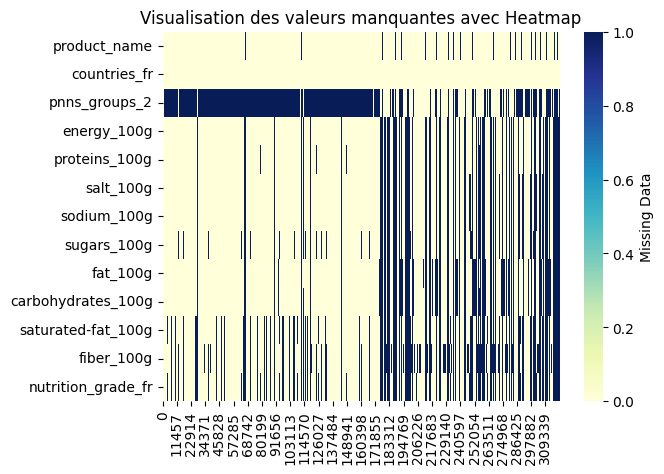

In [3]:
def introducing_data():
    '''Import des données provenant du fichier csv dans un dataframe et affichage du pourcentage des valeurs manquantes
    Output : Dataframe'''
    df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep = "\t")
    print(f"Le jeu de données comporte {df.shape[0]} lignes et {df.shape[1]} colonnes")
    display(df.isna().mean().sort_values())
    return df

def select_variables(df):
    ''' Selection des variables pertinentes, affichage des informations sur ces variables et visualisation des valeurs manquantes
    Input : Dataframe, Output : Dataframe'''
    df = df[df.columns[df.isna().mean() < 0.9]]
    cols = ['product_name', 'countries_fr', 'pnns_groups_2', 'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fiber_100g','nutrition_grade_fr']
    df = df[cols]
    display(df.describe())
    display(df.info())
    display(df.isna().mean().sort_values())
    sns.heatmap(df.isna().T,cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
    plt.title("Visualisation des valeurs manquantes avec Heatmap")
    return df
    
df = introducing_data()
df = select_variables(df)

## Suppresion de données inexploitables

### Vérification et suppression des doublons

In [4]:
def drop_duplicates(df):
    '''Suppression des produits dupliqués
    Input: Dataframe, Output : Dataframe'''
    duplicate = df[df.duplicated()] 
    print(f"Il existe {duplicate.shape[0]} doublons dans notre jeu de données")
    df = df.drop_duplicates()
    return df
df = drop_duplicates(df)

Il existe 36591 doublons dans notre jeu de données


### Suppression valeurs aberrantes

**Tableau fixant les éventuelles valeurs aberrantes en tenant compte du contexte métier**

**Valeurs limites pour .max :**  
-Max de energy. 3700kj  
-Max de proteins_100g. Spiruline en poudre : 57,5 gr.  
-Max de salt_100g. Sel non iodé non fluoré : 100,00 gr  
-Max de sodium. Sel non iodé non fuoré : 100/ 2,5 = 40 gr    
-Max sugars_100gr. Sucre : 100gr  
-Max fat_100gr. Huile : 100gr  
-Max carbohydrates_100gr (glucides). Max = Sucre = 100gr  
-Max saturated-fat_100gr. Pains de friture = 92,60gr  
-Max fiber_100gr. Graines de chia = 38gr 

<!-- -Max cholesterol_100gr. Cervelle de porcs : 2195 mg.  
-Max trans-fat_100gr. pain de friture : 92,60gr  
-Max calcium_100gr. Basilic séché : 2240 mg   
-Max vitamin-c_100gr. Prune de kakadu : 3200mg  
-Max iron_100gr. Le foie de porc : 18mg  
-Max vitamin-a_100gr. L’huile de foie de morue : 30 000 µg/100g   -->

#### Suppression des valeurs négatives

In [5]:
def drop_negatives(df):
    '''Suppression des produits contenant des valeurs négatives
    Input: Dataframe, Output : Dataframe'''
    list_x = []
    for i in df.select_dtypes('float'):
        df_negative = df.loc[df[i] < 0, : ]
        list_x.append(df_negative)

    df_negative = pd.concat(list_x)    
    print(f"Il existe {df_negative.shape[0]} produits avec des valeurs négatives")
    df.drop(df_negative.index, axis = 0, inplace=True)
    return df

df = drop_negatives(df)

Il existe 11 produits avec des valeurs négatives


#### Variable 'product_name' 'countries_fr'

Suppression des valeurs manquantes pour 'product_name', 'countries_fr' car difficile à imputer

In [6]:
def drop_products(df):
    '''Suppression des produits ne contenant pas de nom de produits ou de pays de provenance
    Input: Dataframe, Output : Dataframe'''
    index_nan = df.loc[(df.countries_fr.isna()) | (df.product_name.isna()), :].index
    print(f"Le nombre de produits dont le nom, le pays ou la marque sont absents est de {index_nan.shape[0]}")
    df.drop(index_nan, axis = 0, inplace = True)
    return df

df = drop_products(df)

Le nombre de produits dont le nom, le pays ou la marque sont absents est de 3794


#### Variable 'energy_100g'

-Suppression des valeurs supérieures à 3700kj pour la variable énergie (900kcal = 3700kj) ce qui représente un pourcentage de 100% de graisses pour 100g)   

In [7]:
def drop_energy_outiers(df):
    '''Suppression des produits contenant plus de 3700kj dans la variable energy (incohérent)
    Input: Dataframe, Output : Dataframe'''
    energy_outliers = df.loc[df['energy_100g'] > 3_700, : ].index
    print(f"Il existe {energy_outliers.shape[0]} valeurs aberrantes")
    df.drop(energy_outliers, axis = 0, inplace=True)
    print(df.energy_100g.describe().round(2))
    return df

df = drop_energy_outiers(df)

Il existe 581 valeurs aberrantes
count    238042.00
mean       1117.73
std         773.91
min           0.00
25%         389.00
50%        1100.00
75%        1674.00
max        3700.00
Name: energy_100g, dtype: float64


####  Variable 'salt_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'fiber_100g'

In [8]:
def drop_inconsistent_data(df):
    '''Suppression des aliments dont les valeurs sont supérieures à 100g pour 100g de produits (incohérent)
    Input: Dataframe, Output : Dataframe'''
    cols =['salt_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 'fiber_100g']
    list_x= []
    for i in df[cols]:
        outliers = df.loc[df[i] > 100, :]
        list_x.append(outliers)    
    df_outliers = pd.concat(list_x)
    print(f"Il existe {df_outliers.shape[0]} produits avec des valeurs incohérentes")
    df.drop(df_outliers.index, axis = 0, inplace=True)
    return df

df = drop_inconsistent_data(df)

Il existe 158 produits avec des valeurs incohérentes


#### Variable sugars et carbohydrates - Variable fat et saturated-fat

Suppressions des produits dont le sucre est supérieur en quantité aux glucides (incohérent)  
Suppression des produits dont la quantité de graisse saturée est supérieur à la quantité de graisse (incohérent)

In [9]:
def drop_sugars_outliers(df):
    '''Suppression des aliments dont le sucre est supérieur aux glucides et dont les graisses saturées est supérieur aux graisses.
    Input: Dataframe, Output : Dataframe'''
    sugar_aberrants = df.loc[df['sugars_100g'] > df['carbohydrates_100g'], :].index
    print(f" Le nombre de produits ou les sucres ont des valeurs aberrantes est de {sugar_aberrants.shape[0]}")
    df.drop(sugar_aberrants, axis= 0, inplace= True)
    fat_abberrants = df.loc[df['saturated-fat_100g'] > df['fat_100g'], :].index
    print(f" Le nombre de produits ou les graisses ont avec des valeurs aberrantes est de {fat_abberrants.shape[0]}")
    df.drop(fat_abberrants, axis= 0, inplace= True)
    return df

df = drop_sugars_outliers(df)

 Le nombre de produits ou les sucres ont des valeurs aberrantes est de 665
 Le nombre de produits ou les graisses ont avec des valeurs aberrantes est de 324


#### Suppresion des valeurs dont la somme cumulée des nutriments est supérieur à 100g

In [10]:
def drop_sum_nutrients(df):
    '''Suppresion des produits dont la somme cumulée des nutriments est supérieur à 100g
    Input: Dataframe, Output : Dataframe'''
    nb = sum(df[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g', 'salt_100g']].sum(axis=1)>100)
    print("Le nombre de produits dont la somme cumulée des nutriments est supérieur à 100g de macro nutriments est de : {}".format(nb))
    df  = df [df[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g', 'salt_100g']].sum(axis=1)<100]
    return df

df = drop_sum_nutrients(df)

Le nombre de produits dont la somme cumulée des nutriments est supérieur à 100g de macro nutriments est de : 19379


### Variable Sel et Sodium

In [11]:
df[['salt_100g', 'sodium_100g']].corr()
df.drop(columns= "sodium_100g", inplace=True)

Il y a une corrélation totale entre la variable 'salt_100g' et 'Sodium_100g'. Il n'est donc pas nécessaire de conserver les deux variables

### Produits dont on possède le moins de données

**Remarque**  
Ces produits vont être compliqués à imputer car on a très peu voir pas d'informations.    
Nous allons devoir les supprimer de notre échantillon pour pouvoir nous concentrer sur l'imputation des individus qui possèdent partiellement des données.

In [12]:
def drop_empty_data(df):
    '''Suppresion des produits dont on ne possède aucune information sur les nutriments.
    Input: Dataframe, Output : Dataframe'''
    nutriments = ['sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g', 'energy_100g']
    data_empty = df[df[nutriments].isnull().sum(axis=1) > 6]
    display(data_empty)
    print(f"Il existe {data_empty.shape[0]} produits dont il manque toutes les données sur les nutriments.")    
    df.drop(data_empty.index, axis= 0, inplace= True)
    return df

df = drop_empty_data(df)

,product_name,countries_fr,pnns_groups_2,energy_100g,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,nutrition_grade_fr
0,Farine de blé noir,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,Filet de bœuf,France,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,Twix x2,France,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,Flute,Royaume-Uni,Bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,still Scottish water,Royaume-Uni,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
320764,"Cheese cake thé vert, yuzu",France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,Rillette d'oie,France,Processed meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320767,Tomato & ricotta,Roumanie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320769,乐吧泡菜味薯片,Chine,Appetizers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Il existe 40338 produits dont il manque toutes les données sur les nutriments.


### Variable fibre et proteines

In [13]:
outliers = df.loc[(df['fiber_100g'] > 38) | (df['proteins_100g']> 58), :]
print(f"Il y a {outliers.shape[0]} produits dont les données sont inconhérentes pour la variable fibre ou protéines.")
df.drop(outliers.index, axis= 0, inplace= True)

Il y a 311 produits dont les données sont inconhérentes pour la variable fibre ou protéines.


### Variable 'nutrition_grade'

In [14]:
print(f"Il existe {df['nutrition_grade_fr'].isna().sum()} produits sans nutri-score")
df.dropna(subset=['nutrition_grade_fr'], inplace = True)

Il existe 33441 produits sans nutri-score


## Imputation des données manquantes

**A ce stade, voici les variables avec leur pourcentages de valeurs manquantes**

In [15]:
df.isna().mean().sort_values()

product_name          0.000000
countries_fr          0.000000
energy_100g           0.000000
proteins_100g         0.000000
salt_100g             0.000000
sugars_100g           0.000000
saturated-fat_100g    0.000000
nutrition_grade_fr    0.000000
fat_100g              0.092491
carbohydrates_100g    0.092660
fiber_100g            0.138443
pnns_groups_2         0.679013
dtype: float64

### Variable fibre

**Remplissage des valeurs manquantes pour les fibres**  
Les quantités de fibre n'étant pas nécessairement renseigné sur les produits.  
On partira du postulat que si l'information n'est pas présente, c'est que sa valeur est nulle.

In [16]:
df["fiber_100g"] = df["fiber_100g"].fillna(0)

### Variables carbohydrates et fat.

On se servira de nos variables fiber et sugars afin d'imputer la variable carbohydrates.  
On se servira de notre variable saturated-fat afin d'imputer la variable fat

In [17]:
nutriments = ['energy_100g','sugars_100g','carbohydrates_100g','saturated-fat_100g','fat_100g', 'proteins_100g']

def impute_data(data, columns, imputer):
    '''Imputation des valeurs manquantes pour les colonnes fournis en paramètre de la fonction.
    Input: Dataframe, Colonnes concernées, Imputer, Output : Colonnes concernées avec données imputées'''
    X = data[columns]
    display(X)
    features = X.columns
    X_scaled = imputer.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled)
    X_scaled.columns = features
    display(X_scaled)
    data = X_scaled
    return data

def apply_constraints(row):
    '''Application d'une contrainte sur les variable glucides/sucres et sur les variables lipides/graisses_saturées
    Input: Dataframe, Output : Dataframe'''
    if row['sugars_100g'] > row['carbohydrates_100g']:
        row['sugars_100g'] = row['carbohydrates_100g']
    if row['saturated-fat_100g'] > row['fat_100g']:
        row['saturated-fat_100g'] = row['fat_100g']
    return row

def replace_imputed(df, df_impute, col):
    '''Remplacement dans le dataframe original des valeurs manquantes par les valeurs imputées
    Input: Dataframe, Données imputées, Colonnes concernées'''
    for i in df[col]:
        df[i] = df[i].fillna(df_impute[i])

In [18]:
imputer = KNNImputer()
data_imputed = impute_data(df, nutriments, imputer)
df = df.reset_index(drop=True)
replace_imputed(df, data_imputed, nutriments)
df = df.apply(apply_constraints, axis=1)

,energy_100g,sugars_100g,carbohydrates_100g,saturated-fat_100g,fat_100g,proteins_100g
12,2230.0,3.33,36.67,5.00,36.67,16.67
19,1096.0,2.38,66.67,1.19,5.95,16.67
20,1464.0,32.50,42.50,7.50,17.50,7.50
23,2372.0,6.67,23.33,3.33,50.00,6.67
24,1954.0,33.33,60.00,2.22,20.00,8.89
...,...,...,...,...,...,...
320742,1477.0,2.35,87.06,0.00,0.00,1.18
320751,1643.0,2.60,74.80,0.60,2.80,13.00
320757,2406.0,3.89,NaN,3.73,NaN,21.22
320763,21.0,0.50,0.50,0.20,0.20,0.50


,energy_100g,sugars_100g,carbohydrates_100g,saturated-fat_100g,fat_100g,proteins_100g
0,2230.0,3.33,36.67,5.00,36.67,16.67
1,1096.0,2.38,66.67,1.19,5.95,16.67
2,1464.0,32.50,42.50,7.50,17.50,7.50
3,2372.0,6.67,23.33,3.33,50.00,6.67
4,1954.0,33.33,60.00,2.22,20.00,8.89
...,...,...,...,...,...,...
182554,1477.0,2.35,87.06,0.00,0.00,1.18
182555,1643.0,2.60,74.80,0.60,2.80,13.00
182556,2406.0,3.89,18.46,3.73,48.28,21.22
182557,21.0,0.50,0.50,0.20,0.20,0.50


### Variable "pnns_groups_2" (catégorie de l'aliment)

Pour imputer cette variable qui possèdent une majorité de valeurs manquantes de manière la plus précise possible, nous allons entrainer un modèle sur les données disponibles afin de l'utiliser pour l'imputation.  
Afin d'exploiter la variable 'nutrition_grade_fr' pour nous aider à imputer la variable pnns_groups_2, un remplacement des modalités catégoriques par un numérique est nécessaire.  
Nous remplacerons les produits marqués en "unknown" par des np.nan pour les inclure dans l'imputation.  
Enfin, il faudra supprimer les doublons de catégorie, la variable pnns_groups_2 comporte 5 modalités étant des doublons.

In [19]:
def drop_category_duplicates(df):
    '''Suppression des doublons de catégorie d'aliment, remplacement du nutriscore par des numériques, remplacement des aliments
    de catégorie "Unknown" par des valeurs manquantes, réinitialisation de l'index.
    Input: Dataframe, Output: Dataframe'''
    df['nutrition_grade_fr'].replace(['a', 'b', 'c','d', 'e'], [0, 1, 2, 3, 4], inplace=True)
    df['pnns_groups_2'].replace("unknown", np.nan, inplace = True)
    duplicata_modal = df.loc[(df['pnns_groups_2'] == "nuts")| (df['pnns_groups_2'] == "vegetables") |
                             (df['pnns_groups_2'] == "cereals") | (df['pnns_groups_2'] == "legumes") |
                             (df['pnns_groups_2'] == "fruits"), :]
    print(f"Il existe {duplicata_modal.shape[0]} produits ayant un doublon de catégorie")
    df.drop(duplicata_modal.index, axis= 0, inplace = True)
    df = df.reset_index(drop=True)
    return df

df = drop_category_duplicates(df)

Il existe 678 produits ayant un doublon de catégorie


Ci dessous, les variables qui vont nous servir à prédire la catégorie de l'aliment.  
Nous utiliserons LabelEncoder pour encoder notre variable pnns_groups_2 et pour la décoder par la suite.

In [20]:
columns = ['sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g', 'energy_100g', 'nutrition_grade_fr']

# LabelEncoder va être utilisé pour encoder notre variable pnns_groups_2 de type catégorielle.
le = LabelEncoder()

In [21]:
def fit_model(df):
    '''Suppression des valeurs manquantes, encodage des catégories d'aliments, séparation du dataframe en données d'entrainement
    et en données de test, entrainement du modèle et affichage du score de précision.
    Input: Dataframe, Output: Modèle de machine learning'''
    # Suppression des lignes contenant des valeurs manquantes dans les variables explicatives et la variable cible
    df_clean = df.dropna(subset=['sugars_100g', 'carbohydrates_100g', 'fat_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g', 'energy_100g', 'nutrition_grade_fr', 'pnns_groups_2'])

    # Séparation du dataset en variables explicatives et variable cible
    X = df_clean[columns]
    y = df_clean['pnns_groups_2']
    y_encoded = le.fit_transform(y)

    # Séparation du dataset en conjoints d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y)

    # Création et entraînement du modèle 
    model = RandomForestClassifier(n_estimators= 200, max_depth = None, min_samples_leaf= 1, min_samples_split= 2)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    accuracy_rounded = round(accuracy, 2)
    
    print(f"La performance du modèle est de {accuracy_rounded * 100} %")
    return model  

model = fit_model(df)

La performance du modèle est de 85.0 %


In [22]:
def use_model(df):
    '''Prediction des données dans la variable pnns_groups_2 grace au modèle entrainé précedemment, décodage de la 
    variable pnns_groups_2, remplacement des valeurs manquantes par les prédictions du modèle, récupération des 
    modalités originales du nutriscore.
    Input: Dataframe, Output: Dataframe'''
    X = df[columns]
    #Prédiction des catégories d'aliment sur tout le dataframe
    y_pred = model.predict(X)

    # Création du masque de booléens des valeurs manquantes pour la catégorie de l'aliment
    mask = df['pnns_groups_2'].isnull()

    # Récupération des modalités de la variable cible
    y_pred_labels = le.inverse_transform(y_pred)

    # Remplacement des valeurs manquantes par les valeurs prédites
    for i, row in df[mask].iterrows():
        df.at[i, 'pnns_groups_2'] = y_pred_labels[i]
        
    #Récupération des modalités d'origine du nutriscore
    df['nutrition_grade_fr'].replace([0, 1, 2, 3, 4], ['a', 'b', 'c','d', 'e'], inplace=True)
        
    return df

df = use_model(df)

In [23]:
display(df.isna().mean())
display(df.shape)

product_name          0.0
countries_fr          0.0
pnns_groups_2         0.0
energy_100g           0.0
proteins_100g         0.0
salt_100g             0.0
sugars_100g           0.0
fat_100g              0.0
carbohydrates_100g    0.0
saturated-fat_100g    0.0
fiber_100g            0.0
nutrition_grade_fr    0.0
dtype: float64

(181881, 12)

# Exportation des données pour l'analyse

In [24]:
with open('clean_data.bin', 'wb') as fichier:
    pickle.dump(df, fichier)